# How should we call edSites?

serveral previous appers use unified genotyper - but this assumes ploidy. This is not a good assumption for editing sites. We compare with mutect2, which is designed to detect somatic mutation and can handle lower fractions. 

Mutect2 detects RNA-DNA differences, which will be somatic mutations as well as editing. This will differ based on
1. haplotype consistency. edSites will fall on both haplotypes, somatic mutation will always be on one.
2. sharing across individuals. Lots of samples will have the same editing sites. Somatic mutation will be more evenly distributed

In [59]:
import pandas as pd
from cyvcf2 import VCF
import upsetplot as up
import numpy as np
import seaborn as sns

load in an example output from each for a single sample. This is pre-filtering (so likely lots of false positives)

In [2]:
hc_vcf_path = '/home/klawren/oak/gtex/output/test_bams/output_kate/haplotype_caller/GTEX-1C4CL-2126-SM-7IGQC.hc.vcf.gz'
mutect_vcf_path = '/home/klawren/oak/gtex/output/test_bams/output_kate/mutect/GTEX-1C4CL-2126-SM-7IGQC.mutect2.vcf'

In [108]:
hc_vcf = pd.read_csv(hc_vcf_path, comment='#', sep='\t', names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
hc_vcf['AF'] = hc_vcf['INFO'].str.split('AF=').str[1].str.split(';').str[0]
hc_vcf['in'] = True

# split alternate alleles
hc_vcf['ALT'] = hc_vcf['ALT'].str.split(',')
hc_vcf['AF'] = hc_vcf['AF'].str.split(',')
hc_vcf = hc_vcf.explode(['ALT', 'AF'])
hc_vcf['AF']  = hc_vcf['AF'].astype(float)

In [101]:
# load in mutect
mutect_vcf = pd.read_csv(mutect_vcf_path, comment='#', sep='\t', names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
mutect_vcf['in'] = True
mutect_vcf['AF'] = mutect_vcf['SAMPLE'].str.split(':').str[2]

# split alternate alleles
mutect_vcf['ALT'] = mutect_vcf['ALT'].str.split(',')
mutect_vcf['AF'] = mutect_vcf['AF'].str.split(',')
mutect_vcf = mutect_vcf.explode(['ALT', 'AF'])
mutect_vcf['AF']  = mutect_vcf['AF'].astype(float)

combine the vcf to see which variants are discovered by one tool or the other

In [119]:
combined_vcf = pd.merge(mutect_vcf, hc_vcf, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', suffixes=['_mutect', '_hc'])
combined_vcf['in_hc'] = combined_vcf['in_hc'] == True
combined_vcf['in_mutect'] = combined_vcf['in_mutect'] == True
combined_vcf['combined_in'] = np.where(combined_vcf['in_hc'], np.where(combined_vcf['in_mutect'], 'both', 'hc_only'), 'mutect_only')

/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

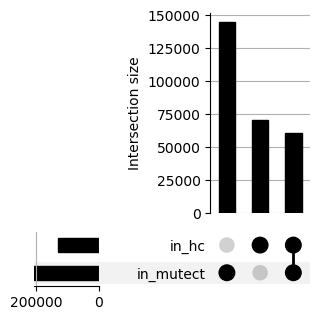

In [120]:
var_upset = up.UpSet(combined_vcf.set_index('in_hc').set_index('in_mutect', append=True))
var_upset.plot()

look at the allele frequencies of the variants

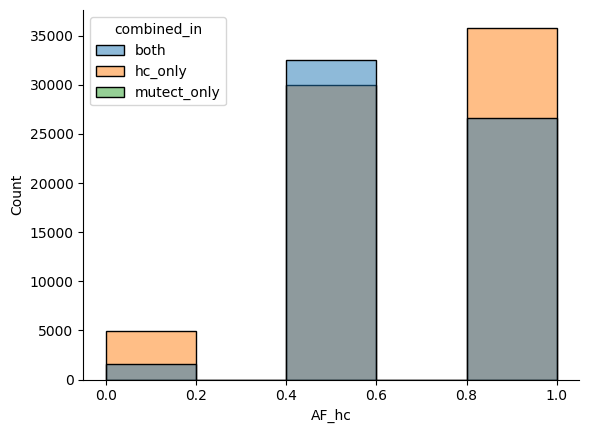

In [143]:
sns.histplot(combined_vcf, x='AF_hc', bins=5, hue='combined_in')
sns.despine()

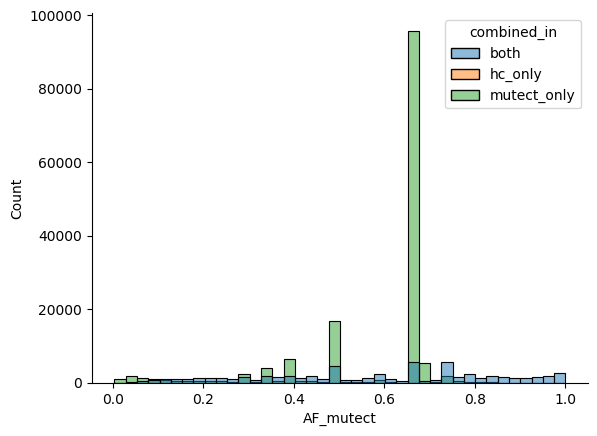

In [137]:
sns.histplot(combined_vcf, x='AF_mutect', bins=40, hue='combined_in')
sns.despine()

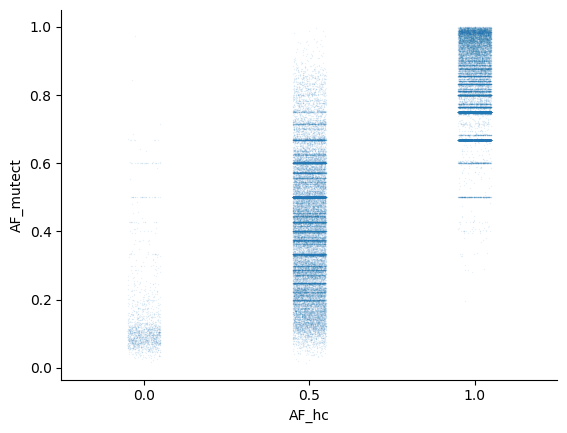

In [138]:
sns.stripplot(combined_vcf, x='AF_hc', y='AF_mutect', alpha=.1, s=1)
sns.despine()

In [ ]:
# do some basic filtering, then look again
!gatk
